#GAN implementation: Anime-Sketch Colorization #
Making a GAN model , which colours an anime-sketch 

**Importing necessary modules**

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import time
import datetime


from google.colab import drive
drive.mount('/content/gdrive')

**Working with Kaggle dataset**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle

In [ ]:
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair

In [ ]:
!unzip \*.zip  && rm *.zip

**Using the Generator and Discriminator functions stored in other files**

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('generator.py','wb').write(src)
src = list(files.upload().values())[0]
open('discriminator.py','wb').write(src)

In [ ]:
from generator import buildGenerator
from discriminator import build_Discriminator

**Constants of computation**

In [ ]:
EPOCHS = 5
BUFFER_SIZE = 14224
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 100

PATH = '/content/gdrive/MyDrive/Kaggle/data'

**Data preprocessing**

In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image
  


In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset  = tf.data.Dataset.list_files(PATH+'/val/*.png')
test_dataset = test_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
generator = buildGenerator()
discriminator = build_Discriminator()

**Building the GAN model**

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [ ]:

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
 

In [ ]:
checkpoint_dir = './Sketch2Color_training_checkpoints/final'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)


In [ ]:

def generate_images(model , test_input , tar):
  prediction = model(test_input , training = True)
  plt.figure(figsize = (15,15))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  assert(prediction[0].shape == tar[0].shape) #check if processing of images was done correctly by Generator
  for i in range(3):
   plt.subplot(1, 3, i+1)
   plt.title(title[i])
   plt.imshow(display_list[i] * 0.5 + 0.5)
   plt.axis('off')
  plt.show()

In [ ]:
log_dir="Sketch2Coloe_logs/"
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [ ]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds, epochs ,test_ds):
    for epoch in range(epochs):
        start = time.time()

        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        for example_input, example_target in test_ds.take(1):
          generate_images(generator, example_input, example_target)
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
fit(train_dataset , 10,test_dataset)
#The 10 here is just so that we can stop for some breaks in case of errors , and repeat cell activity in case of no errors. 
#This model takes roughly 60~65 epochs to allign to a decent output.

(256, 256, 3) (256, 256, 3)


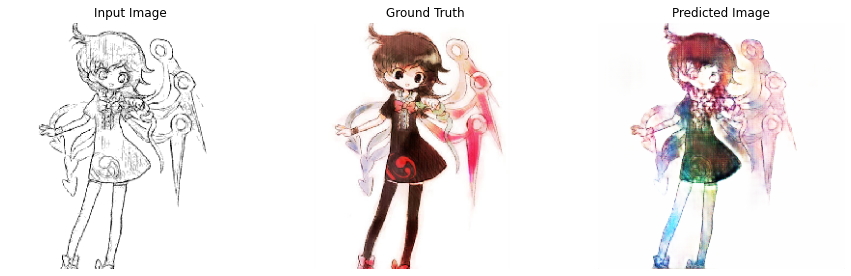

(256, 256, 3) (256, 256, 3)


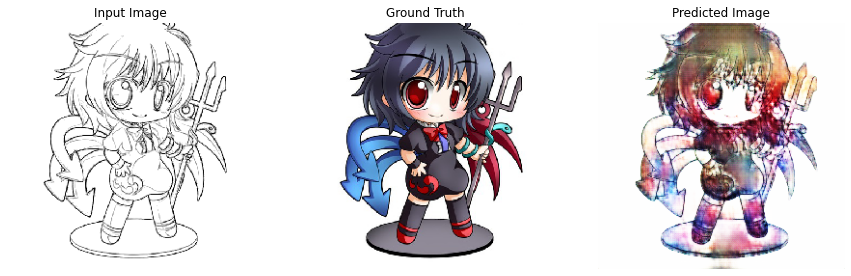

(256, 256, 3) (256, 256, 3)


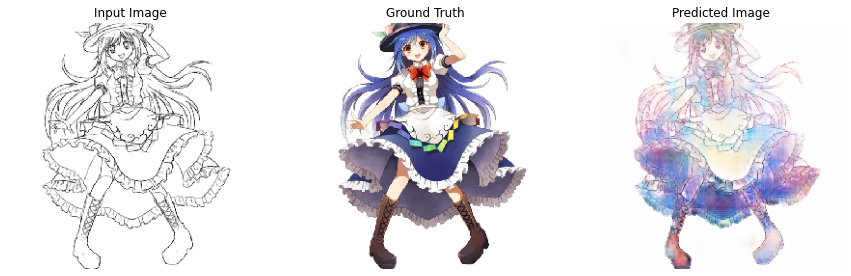

(256, 256, 3) (256, 256, 3)


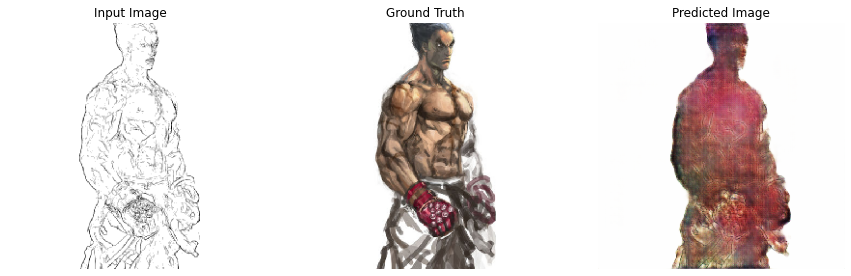

(256, 256, 3) (256, 256, 3)


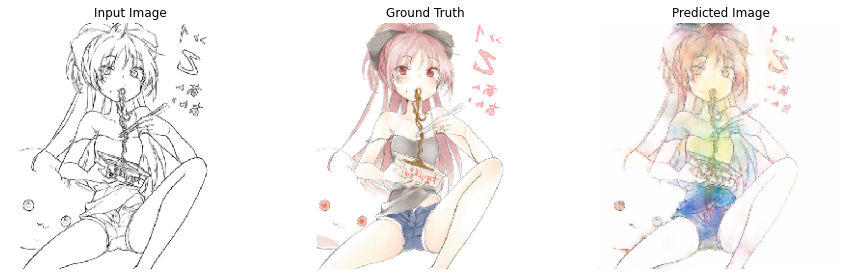

In [ ]:
for example_input, example_target in train_dataset.take(5):
 generate_images(generator, example_input, example_target)